## Identify the snake breed
Max. score: 100
#### Problem statement
The government has been facing a long-standing issue of wild animals entering residential areas due to various reasons. It's of critical importance that if any such dangerous animal is encountered, the concerned authority should be notified immediately. Reptiles, especially snakes, are among the most dangerous animals and they often enter residential areas. 

Recently due to an incident of a youngster getting bitten by a snake, the government decided to install cameras at every corner of the road to detect snakes and other animals.

You have been hired as a Deep Learning engineer to create a sophisticated model that can detect the breed of a snake from its image.

#### Data description
This data set consists of the following two columns:

#### Column Name	Description
image_id	Name of the image file
breed	Snake breed [35 different breeds]
The data folder consists of two folders and two .csv files. The details are as follows:

train: Contains 5508 images for 35 classes 
test: Contains 2361 images
train.csv: 5508 x 2
test.csv: 2361 x 1
Submission format
You are required to write your predictions in a .csv file and upload it by clicking the Upload File button.

#### Sample submission

image_id,breed
a8b3ad1dde,nerodia-erythrogaster
8b492b973d,pantherophis-vulpinus
929b99ea92,thamnophis-sirtalis
bbac7385e2,pantherophis-obsoletus
ef776b1488,agkistrodon-contortrix
Evaluation metric

####  Note: To avoid any discrepancies in the scoring, ensure that all the index column (image_id) values in the submitted file match the values in the provided test.csv file.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# google colab
# from google.colab import files,drive
# drive.mount("")
root = ""

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
import datetime
# for tensorboard
log_dir = root + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [5]:
# bash sciprt to kill any tensorboard instances
# !ps -ef | grep "/home/saurav/anaconda3/envs/datascience/bin/tensorboard --logdir logs/fit" | 

# tensorboard customisation to sort the logs in time

In [6]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 20709), started 0:02:24 ago. (Use '!kill 20709' to kill it.)

Dataset

In [7]:
data_dir = root + "./8a95c26e1bab11eb/dataset/tfData/train"
batch_size = 4
img_height = 112
img_width=112
num_classes = 35


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5508 files belonging to 35 classes.
Using 4407 files for training.
Found 5508 files belonging to 35 classes.
Using 1101 files for validation.


model

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [9]:
# finetuning
# Create the base model from the pre-trained model MobileNet V2
BATCH_SIZE = 32
IMG_SIZE = (160, 160)


IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(4, 3, 3, 1280)


In [10]:
base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(4, 1280)


In [12]:
prediction_layer = tf.keras.layers.Dense(35)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(4, 35)


In [13]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback])

Epoch 1/3
   1/1102 [..............................] - ETA: 0s - loss: 4.4983 - accuracy: 0.0000e+00WARNING:tensorflow:From /home/saurav/anaconda3/envs/datascience/lib/python3.5/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1102/1102 [==============================] - 33s 30ms/step - loss: 4.3009 - accuracy: 0.0651 - val_accuracy: 0.0881 - val_loss: 3.8770
Epoch 2/3
1102/1102 [==============================] - 23s 21ms/step - loss: 3.7043 - accuracy: 0.1148 - val_accuracy: 0.1172 - val_loss: 3.5837
Epoch 3/3
1102/1102 [==============================] - 23s 21ms/step - loss: 3.3800 - accuracy: 0.1572 - val_accuracy: 0.1362 - val_loss: 3.4034


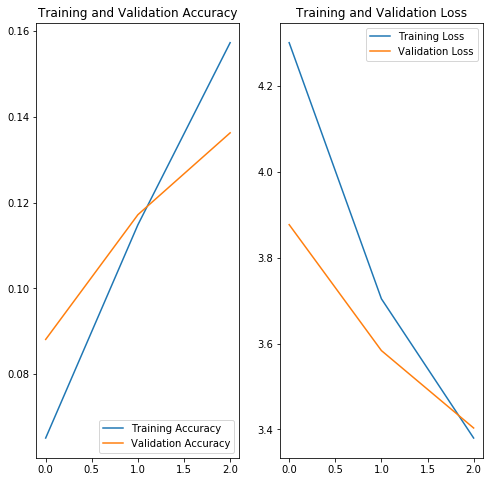

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

submission

In [18]:
import pathlib
import PIL

img_paths = root + "./8a95c26e1bab11eb/dataset/test"
data_dir = pathlib.Path(img_paths)
roses = list(data_dir.glob('*.jpg'))

LABELS = train_ds.class_names

# submission
submission_data = []

for img_index in range(len(roses)):    
    
    image = tf.keras.preprocessing.image.load_img(str(roses[img_index]))
    
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    
    predictions = model.predict(input_arr)
    
    label = LABELS[np.argmax(predictions)]
    
    image_id = str(roses[img_index]).split("/")[-1].split(".")[0]

    submission_data.append([image_id,label])
else:
    print("Done. Saving in dataframe for Submission")
    submission_data = pd.DataFrame(data=submission_data,columns=["image_id","breed"],index=None)
    print(submission_data.head())

Done. Saving in dataframe for Submission
     image_id                     breed
0  b68aec61a9      thamnophis-marcianus
1  eaedb4aeea  lampropeltis-californiae
2  c98bc697c6     pantherophis-guttatus
3  728f07bb97            crotalus-atrox
4  93c3acd68a           storeria-dekayi


In [19]:
import time

if not os.path.exists(root + "./submission"):
    os.mkdir(root + "submission")
save_submission_path = root + "./submission/%s.csv"%(time.ctime())
submission_data.to_csv(save_submission_path,index=False)

# files.download(save_submission_path)

Conclusion